# US Data Charting
This workbooks analyzes the latest US data from the [COVID Tracking project](https://covidtracking.com/),
GitHub [here](https://github.com/COVID19Tracking/covid-tracking).

In [2]:
# @title Download Data
from datetime import datetime, timedelta, timezone
import dateutil.parser as du_parser
import pandas as pd

# MISC functions
reference_day = datetime(2020, 1, 1)
def date_to_day_of_year(date):
    return (date - reference_day).days + 1
def day_of_year_to_date(day_of_year):
    return reference_day + timedelta(days=(day_of_year - 1))
def also_print_df(df, name, date=datetime.now()):
    print("📈 loaded " + name + " dataset (" + date.strftime("%Y-%m-%d") + "): [" + str(len(df)) + " rows x " + str(len(df.columns)) + " columns]: " + ", ".join(list(df)) + "\n")
    return df


# https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data
# FIPS, Admin2, Province_State, Country_Region, Last_Update, Lat, Long_, Confirmed, Deaths, Recovered, Active, Combined_Key
# Issue: US and others are broken down, while Italy for example is whole
def load_latest_johnhopkins_daily():
    tries = 3
    try_date_utc = datetime.utcnow()
    while True:
        try:
            loc_template = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/%m-%d-%Y.csv"
            try_url = try_date_utc.strftime(loc_template)
            df = pd.read_csv(try_url)
            return also_print_df(df, "John Hopkins", try_date_utc)
        except:
            try_date_utc = try_date_utc - timedelta(days=1)
            tries = tries - 1
            if tries is 0:
                print("Out of tries looking for John Hopkins' data (walking back 1 day at a time)")
                exit(1)


# https://github.com/open-covid-19
#  Date, CountryCode, CountryName, RegionCode, RegionName, Confirmed, Deaths, Latitude, Longitude, Population --- sorted by date, ascending
def load_latest_opencovid_feed():
    loc_template = "https://raw.githubusercontent.com/open-covid-19/data/master/output/data.csv"
    df = pd.read_csv(loc_template)
    last_date = du_parser.parse(df.iloc[-1]['Date'])
    last_date = last_date.replace(tzinfo=timezone.utc)
    return also_print_df(df, "Open COVID-19", last_date)


# https://github.com/pcm-dpc/COVID-19/
#  data, stato, ricoverati_con_sintomi, terapia_intensiva, totale_ospedalizzati, isolamento_domiciliare, totale_attualmente_positivi, nuovi_attualmente_positivi, dimessi_guariti, deceduti, totale_casi, tamponi, note_it, note_en
def load_latest_italian_dpc_nationwide_by_date():
    loc_template = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
    df = pd.read_csv(loc_template)
    last_date = du_parser.parse(df.iloc[-1]['data'] + 'Z')
    return also_print_df(df, "Italian PCM-DPC (nationwide by date)", last_date)


#  data, stato, codice_regione, denominazione_regione, lat, long, ricoverati_con_sintomi, terapia_intensiva, totale_ospedalizzati, isolamento_domiciliare, totale_attualmente_positivi, nuovi_attualmente_positivi, dimessi_guariti, deceduti, totale_casi, tamponi, note_it, note_en
def load_latest_italian_dpc_regional_latest():
    loc_template = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-latest.csv"
    df = pd.read_csv(loc_template)
    last_date = du_parser.parse(df.iloc[-1]['data'] + 'Z')
    return also_print_df(df, "Italian PCM-DPC (regional snapshot)", last_date)


CANONICAL_COLS = ['Date', 'X', 'CountryCode', 'CountryName', 'RegionCode', 'RegionName', 'Confirmed', 'Negative', 'Deaths', 'Recovered', 'Hospitalized', 'Tampons', 'dConfirmed', 'dNegative', 'dDeaths', 'dRecovered', 'dHospitalized', 'dTampons', 'Death_rate', 'Tampon_hit_rate', 'dateChecked']


def load_csv(filename: str, keep_cols_map: list or dict, drop_cols: list):
    df = pd.read_csv(filename)
    original_cols = set(df.columns)

    # check if: 1. the data has something extra, 2. the data is missing something we expect
    keep_cols = keep_cols_map if type(keep_cols_map) is list else list(keep_cols_map)
    new_data = original_cols - set(keep_cols + drop_cols)
    if new_data: print(filename + ": data has extra columns: '" + "','".join(new_data) + "'")
    missing_needed = set(keep_cols) - original_cols
    if missing_needed: print(filename + ": missing NEEDED columns: '" + "','".join(missing_needed) + "'")
    missing_ignored = set(drop_cols) - original_cols
    if missing_ignored: print(filename + ": missing former Ignored columns: '" + "','".join(missing_ignored) + "'")

    # safe drop (if a column doesn't exist anymore, don't break)
    df = df.drop(columns=original_cols.intersection(drop_cols))

    # safe reorder + add leftovers. if a column doesn't exist anymore, don't break - although you will have missing data (warned about it already)
    final_columns = [col for col in keep_cols if col in df.columns] + list(new_data)
    df = df.loc[:, final_columns]

    # rename columns, if the 'keep' variable is really a dictionary (it if was a list, skip this)
    if type(keep_cols_map) is dict:
        df = df.rename(columns=keep_cols_map, errors="raise")
    return df


def post_process_entries(filename: str, df, df_regions, is_us_data: bool):
    # add US Country and Regional (State) names
    if is_us_data:
        if 'CountryCode' not in df.columns: df['CountryCode'] = 'US'
        if 'CountryName' not in df.columns: df['CountryName'] = 'United States of America'
        if 'RegionName' not in df.columns and 'RegionCode' in df.columns: df['RegionName'] = df.join(df_regions.set_index('state'), on='RegionCode', how='left')['name']

    # add other canonical values
    df['X'] = df['Date'].map(lambda d: date_to_day_of_year(datetime.strptime(d, '%Y-%m-%d')))
    df['Death_rate'] = 100 * df['Deaths'] / df['Confirmed']
    df['Tampon_hit_rate'] = 100 * df['Confirmed'] / df['Tampons']

    # TODO: add Population (regional, national) so we can have these stats
    # df['Confirmed_pct'] = 100 * df['Confirmed'] / df['Population']
    # df['Deaths_pct'] = 100 * df['Deaths'] / df['Population']

    # check if some columns are not in the canonical list
    extra_canonical_cols = list(set(df.columns) - set(CANONICAL_COLS))
    extra_canonical_cols.sort()
    if extra_canonical_cols: print(filename + ': non-canonical columns: ' + ', '.join(extra_canonical_cols))

    # return the nominal columns: excess columns are discarded, missing columns are NaN
    return df.reindex(columns=CANONICAL_COLS)


# https://covidtracking.com/
#  Date, X, CountryCode, CountryName, RegionCode, RegionName, Confirmed, Negative, Deaths, Recovered, Hospitalized, Tampons, dConfirmed, dNegative, dDeaths, dRecovered, dHospitalized, dTampons, dateChecked
def load_covidtracking_us_data():
    loc_states_info = "https://covidtracking.com/api/states/info.csv"
    loc_states_daily = "http://covidtracking.com/api/states/daily.csv"
    loc_states_latest = "https://covidtracking.com/api/states.csv"  # BARELY USEFUL
    loc_us_daily = "https://covidtracking.com/api/us/daily.csv"

    # US states Information: useful to join the region name (CA -> California)
    def load_us_regions_info():
        return load_csv(loc_states_info, keep_cols_map=['state', 'name', 'fips', 'pui', 'pum', 'notes'], drop_cols=['covid19SiteSecondary', 'twitter', 'covid19Site', 'covid19SiteOld'])

    # US states, daily values
    def load_us_regions_daily(df_regions):
        df = load_csv(loc_states_daily,
                      keep_cols_map={'date': 'Date', 'state': 'RegionCode', 'positive': 'Confirmed', 'negative': 'Negative', 'hospitalizedCurrently': 'Hospitalized', 'hospitalizedCumulative': 'HospitalizedTotal', 'inIcuCurrently': 'InICU', 'inIcuCumulative': 'InICUTotal', 'onVentilatorCurrently': 'OnVentilator', 'onVentilatorCumulative': 'OnVentilatorTotal', 'recovered': 'Recovered', 'death': 'Deaths', 'totalTestResults': 'Tampons', 'positiveIncrease': 'dConfirmed', 'negativeIncrease': 'dNegative', 'deathIncrease': 'dDeaths', 'totalTestResultsIncrease': 'dTampons', 'hospitalizedIncrease': 'dHospitalized', 'dateChecked': 'dateChecked'},
                      drop_cols=['pending', 'hash', 'hospitalized', 'total', 'posNeg', 'fips'])
        df['Date'] = df['Date'].astype(str).map(lambda d: d[:4] + '-' + d[4:6] + '-' + d[6:])
        df = df.reindex(index=df.index[::-1])  # reverse list, so newer is at the bottom
        return post_process_entries(loc_states_daily, df, df_regions, is_us_data=True)

    # US states, latest values (Not very useful, as this is a subset (both rows and colums) of the daily values)
    def load_us_regions_latest(df_regions):
        df = load_csv(loc_states_latest,
                      keep_cols_map={'dateModified': 'Date', 'state': 'RegionCode', 'positive': 'Confirmed', 'negative': 'Negative', 'hospitalizedCurrently': 'Hospitalized', 'hospitalizedCumulative': 'HospitalizedTotal', 'inIcuCurrently': 'InICU', 'inIcuCumulative': 'InICUTotal', 'onVentilatorCurrently': 'OnVentilator', 'onVentilatorCumulative': 'OnVentilatorTotal', 'recovered': 'Recovered', 'death': 'Deaths', 'totalTestResults': 'Tampons', 'dateChecked': 'dateChecked'},
                      drop_cols=['pending', 'hash', 'hospitalized', 'total', 'posNeg', 'fips',
                                 'positiveScore', 'negativeScore', 'negativeRegularScore', 'commercialScore', 'grade', 'score', 'checkTimeEt', 'lastUpdateEt', 'notes'])
        df['Date'] = df['Date'].map(lambda d: du_parser.parse(d).strftime('%Y-%m-%d'))
        return post_process_entries(loc_states_latest, df, df_regions, is_us_data=True)

    # US aggregate, daily values
    def load_us_daily(df_regions):
        df = load_csv(loc_us_daily,
                      keep_cols_map={'date': 'Date', 'states': 'States', 'positive': 'Confirmed', 'negative': 'Negative', 'hospitalizedCurrently': 'Hospitalized', 'hospitalizedCumulative': 'HospitalizedTotal', 'inIcuCurrently': 'InICU', 'inIcuCumulative': 'InICUTotal', 'onVentilatorCurrently': 'OnVentilator', 'onVentilatorCumulative': 'OnVentilatorTotal', 'recovered': 'Recovered', 'death': 'Deaths', 'totalTestResults': 'Tampons', 'positiveIncrease': 'dConfirmed', 'negativeIncrease': 'dNegative', 'deathIncrease': 'dDeaths', 'totalTestResultsIncrease': 'dTampons', 'hospitalizedIncrease': 'dHospitalized', 'dateChecked': 'dateChecked'},
                      drop_cols=['pending', 'hash', 'hospitalized', 'total', 'posNeg'])
        df['Date'] = df['Date'].astype(str).map(lambda d: d[:4] + '-' + d[4:6] + '-' + d[6:])
        df = df.reindex(index=df.index[::-1])  # reverse list, so newer is at the bottom
        return post_process_entries(loc_us_daily, df, df_regions, is_us_data=True)

    # load the 4 APIs
    df_states_info = load_us_regions_info()
    df_states_daily = load_us_regions_daily(df_states_info)  # , 'covid-tracking (US states, daily)')
    df_states_latest = load_us_regions_latest(df_states_info)  # , 'covid-tracking (US states, latest)')
    df_daily = load_us_daily(df_states_info)  # , 'covid-tracking (US country, daily)')
    return df_states_daily, df_states_latest, df_daily


(df_us_states_daily, df_us_states_latest, df_us_daily) = load_covidtracking_us_data()
# df_us_states_daily
# df = df_us_states_daily


http://covidtracking.com/api/states/daily.csv: non-canonical columns: HospitalizedTotal, InICU, InICUTotal, OnVentilator, OnVentilatorTotal
https://covidtracking.com/api/states.csv: non-canonical columns: HospitalizedTotal, InICU, InICUTotal, OnVentilator, OnVentilatorTotal
https://covidtracking.com/api/us/daily.csv: non-canonical columns: HospitalizedTotal, InICU, InICUTotal, OnVentilator, OnVentilatorTotal, States


## US States Charts

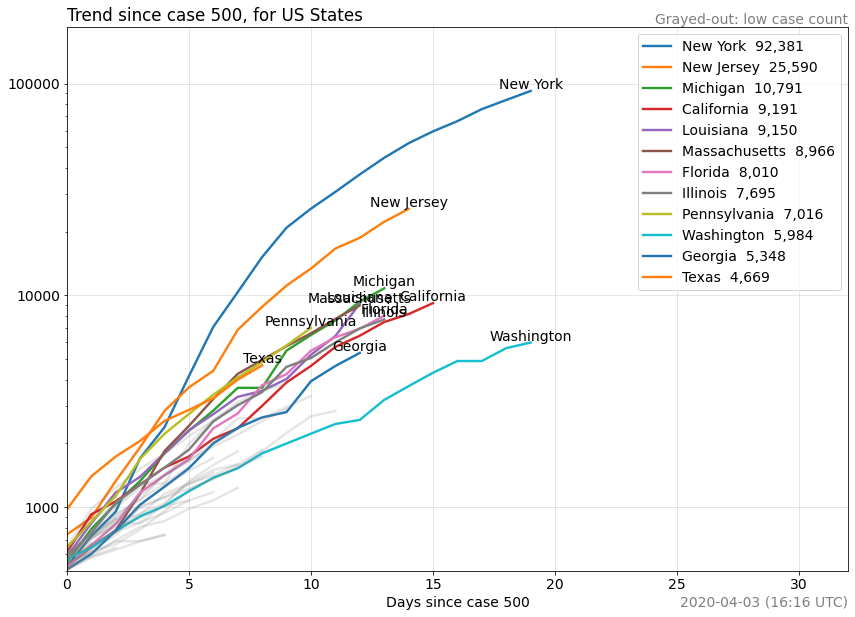

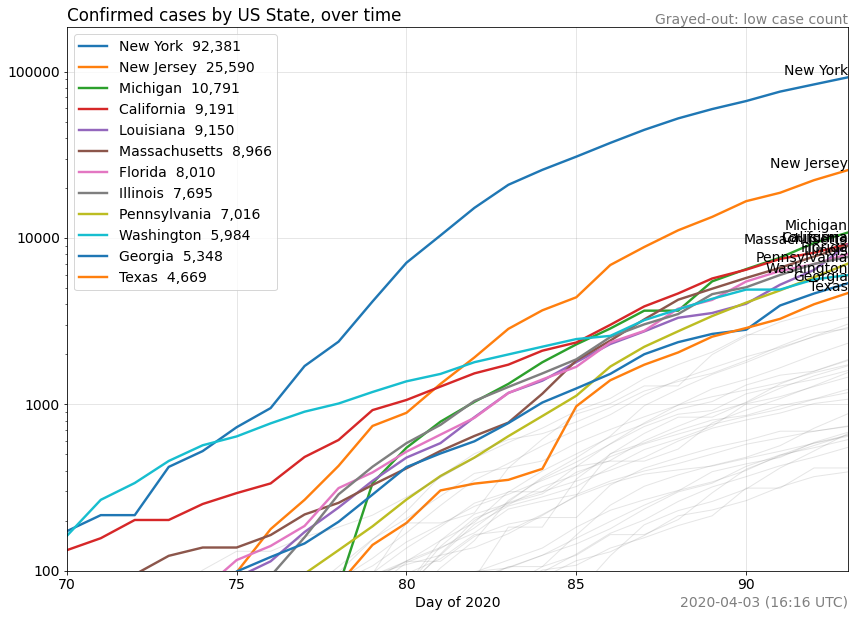

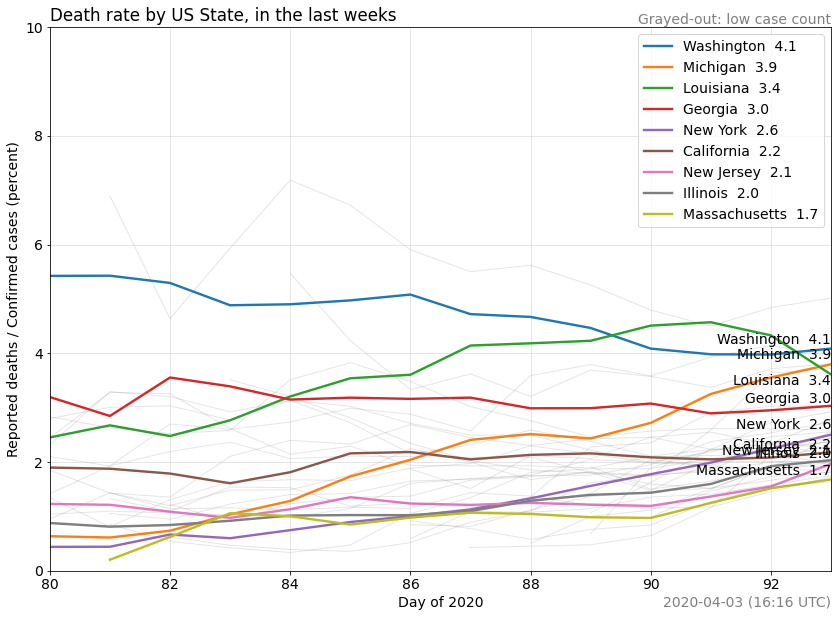

In [14]:
#@title Analyze data, Plot Charts
from datetime import datetime
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
import numpy as np


# Utility function to scatter-plot data frames (multiple series)
def create_xy_plot_by_series(_df,
                             x_key, y_key,                      # [data] keys (column names for X's and Y's)
                             series_key, series_values,         # [series] the key in the df, and all the names
                             series_is_secondary=None,          # [series] function: True -> gray line
                             series_secondary_width=None,       # [series] the width of the line, if secondary
                             shift_x_to_intersect_y=None,       # [transform] translate Series to intersect a point
                             y_filter=None,                     # [transform] filter the y values. valid: 'expo'
                             y_log=False,                       # [axis] make the Y axis logarithmic
                             bounds=[None, None, None, None],   # [axis] x_min, x_max,  y_min, y_max
                             legend_decimals=0,                 # [legend] how many decimals
                             data_labels=None,                  # [data labels] text: legend, series, value
                             data_labels_align="center",        # [data labels] align to: left, right, center
                             title=None, title_align='left', label_x=None, label_y=None, stamp_1=None, stamp_2=None):
    # label the plot
    plt.rc('font', size=14)
    plt.figure(figsize=(14, 10))
    plt.title(title if title else "'" + y_key + "' over '" + x_key + "', by '" + series_key + "'", loc=title_align)
    if not label_x:
        label_x = x_key
        if shift_x_to_intersect_y:
            label_x = label_x + " since crossing " + str(shift_x_to_intersect_y)
    plt.xlabel(label_x)
    if label_y: plt.ylabel(label_y)
    #if not stamp_1: stamp_1 = ""
    if not stamp_2: stamp_2 = "" + datetime.now().strftime("%Y-%m-%d (%H:%M UTC)")

    # add the lines for all the 'countries to chart'
    all_x = []
    all_y = []
    for series_value in series_values:
        # [select rows] get the data of a single series (e.g. a country)
        df = _df[_df[series_key] == series_value]

        # [cleanup] remove 0's, as they don't play well with log
        df = df[df[y_key] > 0]

        # find when the series crosses 100
        x_translation = 0
        if shift_x_to_intersect_y:
            exceeding = df[df[y_key] >= shift_x_to_intersect_y]
            if len(exceeding) == 0:
                continue
            x_translation = -exceeding.iloc[0][x_key]

        # checks if this element should be grayed out
        secondary = series_is_secondary(df) if series_is_secondary else False

        # text of the label (and shorten 'USA')
        series_label = series_value if series_value != "United States of America" else "USA"
        metric_label = round(df[y_key].iloc[-1], legend_decimals)
        if legend_decimals == 0: metric_label = metric_label.astype(int)
        legend_label = series_label + "  " + str(format(metric_label, ',')) + ""
        if secondary: legend_label = None

        # format the color and size
        line_color = (0.5, 0.5, 0.5, 0.2) if secondary else None
        line_width = 2.4
        if secondary and series_secondary_width: line_width = series_secondary_width

        # add the series data
        x = (df[x_key] + x_translation).tolist()
        y = df[y_key].tolist()
        y_plotted = y
        if y_filter == 'expo': y_plotted = df[y_key].rolling(window=(7, 20), win_type='exponential').mean(tau=20)
        plt.plot(x, y_plotted, label=legend_label, color=line_color, linewidth=line_width)
        #plt.plot(x, y, color=(0.8, 0.8, 0.8, 0.4), linewidth=1)
        # plt.scatter(x, y, color=line_color, linewidth=1, alpha=1)

        # add the data label on the endpoint
        if data_labels and not secondary:
            point_label = None
            if data_labels == "series":
                point_label = series_label
            elif data_labels == "value":
                point_label = str(metric_label)
            if data_labels == "legend":
                point_label = legend_label
            # PATCH: remove the label for China in the second chart, or it will be scaled down
            if shift_x_to_intersect_y and series_label == "China": point_label = None
            if point_label:
                plt.annotate(point_label,
                             (x[-1], y[-1]),                # this is the point to label
                             textcoords="offset points",    # how to position the text
                             xytext=(0, 2),                 # distance from text to points (x,y)
                             annotation_clip=False,         # draw over the chart, to spot issues
                             ha=data_labels_align)          # horizontal alignment can be left, right or center

        # for auto bounds
        all_x.extend(x)
        all_y.extend(y)

    # X/Y axes: set-up ranges and scale type
    # boundaries = [left, right, min_y, max_y] <- automatic if any is set to None
    if not bounds: bounds = [None, None, None, None]
    auto_bounds = [min(all_x), max(all_x), np.floor(min(all_y)), np.ceil(max(all_y))]
    bounds = list(map(lambda pair: pair[0] if pair[0] is not None else pair[1], zip(bounds, auto_bounds)))
    if shift_x_to_intersect_y:
        bounds[0] = 0
        bounds[1] = bounds[1] - 10  # magic number, shall remove
        bounds[2] = shift_x_to_intersect_y
    if y_log:
        plt.yscale('log')
        plt.gca().yaxis.set_major_formatter(ScalarFormatter())
        bounds[3] = 2 * bounds[3]
    plt.xlim(bounds[0], bounds[1])
    plt.ylim(bounds[2], bounds[3])

    # add grid
    plt.gca().grid(axis='both', color=(0.4, 0.4, 0.4), alpha=0.2)

    # add legend
    plt.legend()

    # add any decorative text boxes
    if stamp_1:
        plt.text(1, 1, stamp_1, transform=plt.gca().transAxes, alpha=0.5,
                 horizontalalignment='right', verticalalignment='bottom')
    if stamp_2:
        plt.text(1, -0.046, stamp_2, transform=plt.gca().transAxes, alpha=0.5,
                 horizontalalignment='right', verticalalignment='top')

    # display it
    plt.show()


def rank_data_by_metric(df, unique_key, metric, max_results=999, rank_highest=True, select_series_duplicated='last'):
    # [pick latest] for dataset with multiple rows (for days, for example), select only unique values (at the bottom of the frame)
    df = df.drop_duplicates(unique_key, keep=select_series_duplicated)

    # [select rows] remove empty data on the metric itself
    df = df[df[metric].notna()]

    # [select rows] .. more filtering?
    # df = df[df['...'] > ...] # Population > min_population

    # [sort] by the metric, descending
    df = df.sort_values(metric, ascending=(False if rank_highest else True))

    # [reduce] keep the top N results
    df = df.head(max_results)
    return df


# Find the Highest Cases regions
highest_confirmed_by_state = rank_data_by_metric(df_us_states_daily, unique_key='RegionName', metric='Confirmed', max_results=40)
highest_count = highest_confirmed_by_state['Confirmed'].iloc[0].astype(int)
highest_thresh = round(highest_count / 20).astype(int)

# [plot] Days sice Case 500, log
case_threshold = 500
create_xy_plot_by_series(
    df_us_states_daily,
    x_key='X', y_key='Confirmed',
    series_key='RegionName', series_values=highest_confirmed_by_state['RegionName'],
    series_is_secondary=(lambda df: df['Confirmed'].iloc[-1] < highest_thresh),
    shift_x_to_intersect_y=case_threshold,
    y_log=True,
    bounds=[None, (date_to_day_of_year(datetime.now()) - 66) * 1.5, None, None],
    data_labels="series", data_labels_align="center",
    title='Trend since case ' + str(case_threshold) + ', for US States',
    label_x='Days since case ' + str(case_threshold),
    stamp_1="Grayed-out: low case count"
)

# [plot] Day of the year, all series, higher than 100
create_xy_plot_by_series(
    df_us_states_daily,
    x_key='X', y_key='Confirmed',
    series_key='RegionName', series_values=highest_confirmed_by_state['RegionName'],
    series_is_secondary=(lambda df: df['Confirmed'].iloc[-1] < highest_thresh),
    series_secondary_width=1,
    y_log=True,
    bounds=[70, None, 100, None],
    data_labels="series", data_labels_align='right',
    title='Confirmed cases by US State, over time',
    label_x="Day of 2020",
    stamp_1="Grayed-out: low case count"
)

# Mortality
df_highest_death_rate_by_state = rank_data_by_metric(df_us_states_daily, unique_key='RegionName', metric='Death_rate', max_results=40)
create_xy_plot_by_series(
    df_us_states_daily,
    x_key='X', y_key='Death_rate',
    series_key='RegionName', series_values=df_highest_death_rate_by_state['RegionName'],
    series_is_secondary=(lambda df: df['Confirmed'].iloc[-1] < highest_thresh),
    series_secondary_width=1,
    y_filter='expo',
    bounds=[80, None, 0, 10],
    legend_decimals=1,
    data_labels="legend", data_labels_align='right',
    title="Death rate by US State, in the last weeks",
    label_x="Day of 2020", label_y="Reported deaths / Confirmed cases (percent)",
    stamp_1="Grayed-out: low case count"
)
